/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 100	Average Score: 15.81
Episode 200	Average Score: 12.14
Episode 300	Average Score: 10.85
Episode 400	Average Score: 10.33
Episode 500	Average Score: 9.80
Episode 600	Average Score: 9.72
Episode 700	Average Score: 10.65
Episode 800	Average Score: 12.60
Episode 900	Average Score: 13.82
Episode 1000	Average Score: 19.56
Episode 1100	Average Score: 59.26
Episode 1200	Average Score: 151.64
Episode 1300	Average Score: 184.01
Episode 1400	Average Score: 178.74
Episode 1500	Average Score: 170.66
Episode 1600	Average Score: 180.37
Episode 1700	Average Score: 191.38
Episode 1800	Average Score: 190.43
Episode 1900	Average Score: 192.19
Episode 2000	Average Score: 191.91


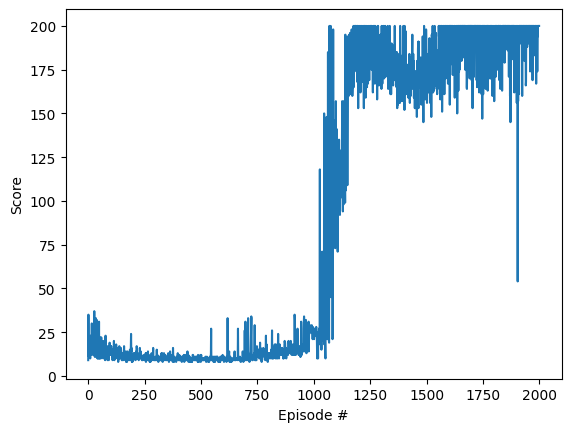

In [1]:
import gym
import random
import numpy as np
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 定义Q网络
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        """初始化模型参数"""
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)  # 第一层全连接，64个节点
        self.fc2 = nn.Linear(64, 64)          # 第二层全连接，64个节点
        self.fc3 = nn.Linear(64, action_size) # 输出层，全连接到动作空间大小

    def forward(self, state):
        """构建网络的前向传播"""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # 输出Q值

# 定义DQN智能体
class DQNAgent:
    def __init__(self, state_size, action_size, seed):
        """初始化智能体参数"""
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q网络
        self.qnetwork_local = QNetwork(state_size, action_size, seed)  # 本地网络
        self.qnetwork_target = QNetwork(state_size, action_size, seed) # 目标网络
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=5e-4)  # 优化器

        # 经验回放缓存
        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)
        self.batch_size = 64
        self.gamma = 0.99        # 折扣因子
        self.tau = 1e-3          # 软更新参数
        self.update_every = 4    # 学习频率
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        """将经验存储到缓存，并定期进行学习"""
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # 如果缓存中有足够的样本，则取样进行学习
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        """根据当前策略选择动作，使用ε-贪心策略"""
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.qnetwork_local.eval()  # 评估模式
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()  # 训练模式

        # ε-贪心策略
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())  # 选择最优动作
        else:
            return random.choice(np.arange(self.action_size))   # 随机探索

    def learn(self, experiences, gamma):
        """从一批经验中学习并更新网络参数"""
        states, actions, rewards, next_states, dones = experiences

        # 获取下一个状态的最大Q值（目标网络）
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # 计算Q目标值
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # 获取当前状态的Q值（本地网络）
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # 计算损失函数
        loss = F.mse_loss(Q_expected, Q_targets)
        # 反向传播并更新参数
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 软更新目标网络
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        """软更新模型参数"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# 定义经验回放缓存
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """初始化缓存参数"""
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # 有限容量的双端队列
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",
                                     field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """添加新的经验到缓存"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """随机采样一批经验"""
        experiences = random.sample(self.memory, k=self.batch_size)

        # 将经验转换为张量
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """返回缓存当前的大小"""
        return len(self.memory)

# 训练DQN智能体
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """DQN学习过程"""
    scores = []                        # 每一集的得分列表
    scores_window = deque(maxlen=100)  # 最近100集的得分
    eps = eps_start                    # 初始化探索率

    for i_episode in range(1, n_episodes+1):
        state = env.reset()            # 重置环境
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)            # 选择动作
            next_state, reward, done, _ = env.step(action)  # 执行动作
            agent.step(state, action, reward, next_state, done)  # 学习一步
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)    # 保存最近的得分
        scores.append(score)           # 保存总得分
        eps = max(eps_end, eps_decay*eps)  # 减小探索率

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
            print('\n环境在 {:d} 集后解决!\t平均得分: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')  # 保存模型
            break
    return scores

# 主程序
if __name__ == '__main__':
    env = gym.make('CartPole-v0')  # 创建环境
    env.seed(0)
    agent = DQNAgent(state_size=4, action_size=2, seed=0)  # 初始化智能体
    scores = dqn()  # 开始训练

    # 绘制得分曲线
    plt.figure()
    plt.plot(np.arange(len(scores)), scores)
    plt.xlabel('Episode #')
    plt.ylabel('Score')
    plt.show()


In [4]:
class PPOAgent:
    def __init__(self, state_dim, action_dim):
        self.policy_net = PolicyNetwork(state_dim, action_dim)
        self.value_net = ValueNetwork(state_dim)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=1e-3)
        self.epsilon = 0.2  # PPO剪辑参数
        self.gamma = 0.99   # 折扣因子

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.policy_net(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action).detach()  # 断开计算图
        return action.item(), log_prob

    def compute_advantages(self, rewards, values, next_values):
        advantages = []
        gae = 0
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.gamma * next_values[i] - values[i]
            gae = delta + self.gamma * gae
            advantages.insert(0, gae)
        return advantages

    def update(self, trajectories):
        states = torch.tensor(np.array([t[0] for t in trajectories]), dtype=torch.float32)
        actions = torch.tensor([t[1] for t in trajectories], dtype=torch.int64)
        old_log_probs = torch.stack([t[2] for t in trajectories])  # 已经在采样时断开计算图
        rewards = [t[3] for t in trajectories]

        # 计算价值
        values = self.value_net(states).squeeze()
        next_values = torch.cat((values[1:], torch.tensor([0.0])))
        advantages = self.compute_advantages(
            rewards, values.detach().numpy(), next_values.detach().numpy())
        advantages = torch.tensor(advantages, dtype=torch.float32)
        returns = advantages + values.detach()

        # 更新策略网络
        for _ in range(10):  # 更新多次
            probs = self.policy_net(states)
            dist = torch.distributions.Categorical(probs)
            log_probs = dist.log_prob(actions)
            ratios = torch.exp(log_probs - old_log_probs)
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * advantages
            policy_loss = -torch.mean(torch.min(surr1, surr2))
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()

        # 更新价值网络
        value_loss = nn.functional.mse_loss(self.value_net(states).squeeze(), returns)
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

env = gym.make('CartPole-v1')
agent = PPOAgent(state_dim=env.observation_space.shape[0], action_dim=env.action_space.n)
for episode in range(1000):
    state = env.reset()
    trajectories = []
    total_reward = 0
    done = False
    while not done:
        action, log_prob = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        trajectories.append((state, action, log_prob, reward))
        state = next_state
        total_reward += reward
    agent.update(trajectories)
    print(f"Episode {episode}, Total Reward: {total_reward}")

Episode 0, Total Reward: 17.0
Episode 1, Total Reward: 15.0
Episode 2, Total Reward: 16.0
Episode 3, Total Reward: 21.0
Episode 4, Total Reward: 17.0
Episode 5, Total Reward: 21.0
Episode 6, Total Reward: 35.0
Episode 7, Total Reward: 24.0
Episode 8, Total Reward: 61.0
Episode 9, Total Reward: 26.0
Episode 10, Total Reward: 41.0
Episode 11, Total Reward: 82.0
Episode 12, Total Reward: 51.0
Episode 13, Total Reward: 25.0
Episode 14, Total Reward: 25.0
Episode 15, Total Reward: 14.0
Episode 16, Total Reward: 24.0
Episode 17, Total Reward: 17.0
Episode 18, Total Reward: 30.0
Episode 19, Total Reward: 21.0
Episode 20, Total Reward: 17.0
Episode 21, Total Reward: 32.0
Episode 22, Total Reward: 32.0
Episode 23, Total Reward: 19.0
Episode 24, Total Reward: 33.0
Episode 25, Total Reward: 28.0
Episode 26, Total Reward: 35.0
Episode 27, Total Reward: 50.0
Episode 28, Total Reward: 35.0
Episode 29, Total Reward: 54.0
Episode 30, Total Reward: 39.0
Episode 31, Total Reward: 102.0
Episode 32, Total